**Tujuan**: Menebak sebuah gambar apakah itu gambar anjing atau kucing.

**Data set yang digunakan**: Kaggle Cats and Dogs Dataset berisi 25,000 gambar (https://www.microsoft.com/en-us/download/details.aspx?id=54765) yang dipisah menjadi 80% data training dan 20% data test.

# Preparation

Import Packages yang dibutuhkan

In [ ]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds

from sklearn.model_selection import train_test_split

from IPython.display import clear_output
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import io
import requests
import random 
import os
import seaborn as sns

import PIL
from PIL import Image

In [ ]:
pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-perfcp53
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-perfcp53


# Import Data and Data Preparation

Data didownload langsung dari website Microsoft (785 MB)

In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   119M      0  0:00:06  0:00:06 --:--:--  133M


Data masih berbentuk ZIP sehingga harus diunzip dan masuk ke environment Google Colab.

In [ ]:

!unzip -q kagglecatsanddogs_3367a.zip
!ls

replace PetImages/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace PetImages/Cat/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
y
 kagglecatsanddogs_3367a.zip   PetImages        sample_data    save_at_2.h5
'MSR-LA - 3467.docx'	      'readme[1].txt'   save_at_1.h5


Kita akan menggunakan data dari direktori **.PetImages/Cats** dan **.PetImages/Dogs**, namun untuk memperlancar training, data gambar yang corrupted atau bukan berformat JFIF/JPEG.

In [ ]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            os.remove(fpath)                

print( "%d data dihapus." % num_skipped)

1590 data dihapus.


# Pemisahan Training & Test Data Set

Data akan kita pisahkan menjadi 80% training (train_ds) dan 20% untuk test (test_ds)

In [ ]:
img_height = 180
img_width = 180
image_size =(img_height, img_width)
batch_size = 32

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


Gambar terbagi dalam 2 kategori, yaitu: 'Cat' dan 'Dog'

In [ ]:
class_names_train = train_ds.class_names
class_names_test = test_ds.class_names
print(class_names_train, class_names_test)

['Cat', 'Dog'] ['Cat', 'Dog']


Kita coba memvisualisasikan 9 gambar anjing dan kucing

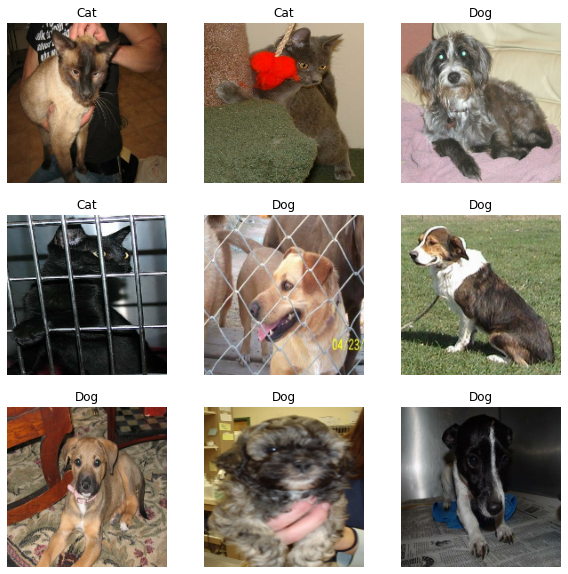

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names_train[labels[i]])
        plt.axis("off")

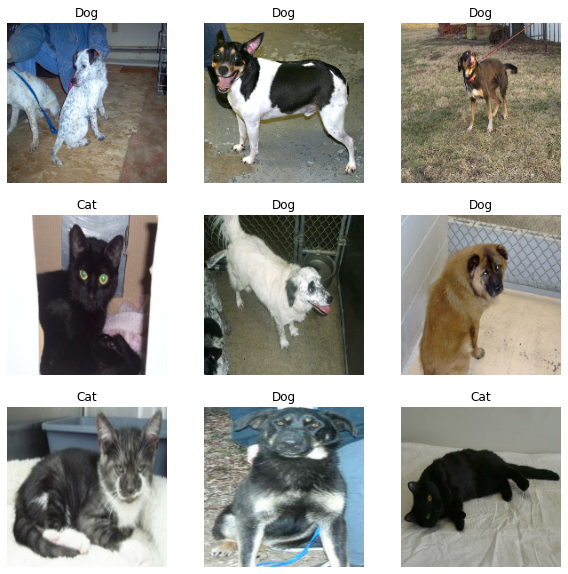

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names_test[labels[i]])
        plt.axis("off")

# Data Augmentation

Data Augmentation diperlukan apabila kita tidak memiliki banyak model gambar, seperti posisi kucing yang berbeda-beda.

In [ ]:
data_augmentation = keras.Sequential(
    [layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),])

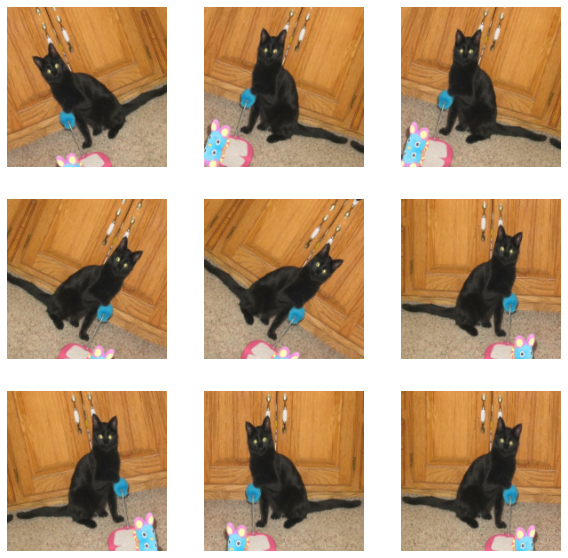

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# Standarisasi Data

In [ ]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
test_ds = test_ds.prefetch(buffer_size=32)

# Membuat Model

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)

# Train the model

In [ ]:
epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=test_ds,
)

Epoch 1/2
586/586 [==============================] - 316s 526ms/step - loss: 0.6184 - accuracy: 0.6704 - val_loss: 1.4807 - val_accuracy: 0.4974


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/2
586/586 [==============================] - 308s 525ms/step - loss: 0.4855 - accuracy: 0.7667 - val_loss: 0.4355 - val_accuracy: 0.8080


# Prediction Test: from Test Dataset

Kita akan coba memprediksi model yang telah dibuat dengan 2 metode: gambar yang ada di dalam test data (test_ds), dan gambar sendiri yang diupload ke internet)

In [ ]:
img_test = "PetImages/Cat/5.jpg"


In [ ]:
img = keras.preprocessing.image.load_img(img_test, target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]

if score > 0.5:
  print("Ini gambar anjing (confidence level %.2f)" % score)
else:
    print("Ini gambar kucing (confidence level %.2f)" % (1-score))

#print(
 #   "This image is %.2f percent cat and %.2f percent dog."
  #  % (100 * (1 - score), 100 * score))

Ini gambar kucing (confidence level 0.68)


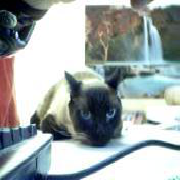

In [ ]:
img

# # Prediction Test: dari Gambar Sendiri

Gambar sudah diupload ke Github dalam bentuk URL.

In [ ]:
what_url = "https://raw.githubusercontent.com/soraya-rk/cat-or-dog/main/prediction_test/test1.jpg"
what_path = tf.keras.utils.get_file('what19', origin=what_url)

what_url3 = "https://raw.githubusercontent.com/soraya-rk/cat-or-dog/main/prediction_test/test2.jpeg"
what_path3 = tf.keras.utils.get_file('what103', origin=what_url3)


73728/68955 [================================] - 0s 0us/step


In [ ]:
img2 = keras.preprocessing.image.load_img(
    what_path, target_size=(img_height, img_width)              
)
img2_array = keras.preprocessing.image.img_to_array(img2)
img2_array = tf.expand_dims(img2_array, 0) # Create a batch

predictions2 = model.predict(img2_array)
score2 = predictions2[0]

if score2 > 0.5:
  print("Ini gambar anjing (confidence level %.2f)" % score2)
else:
    print("Ini gambar kucing (confidence level %.2f)" % (1-score2))

Ini gambar kucing (confidence level 0.83)


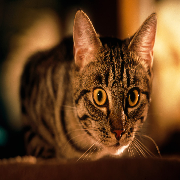

In [ ]:
img2

In [ ]:
img3 = keras.preprocessing.image.load_img(
    what_path3, target_size=(img_height, img_width)              # what_path klo dr URL, what_url kalo dr drive
)
img3_array = keras.preprocessing.image.img_to_array(img3)
img3_array = tf.expand_dims(img3_array, 0) # Create a batch

predictions3 = model.predict(img3_array)
score3 = predictions3[0]

if score3 > 0.5:
  print("Ini gambar anjing (confidence level %.2f)" % score3)
else:
    print("Ini gambar kucing (confidence level %.2f)" % (1-score3))

Ini gambar anjing (confidence level 0.99)


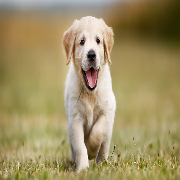

In [ ]:
img3